**Data Description**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Problem statement**

The aim of this exercise is to detect fradulent activity in a real-world dataset of credit card transactions.  As it is essential to figure out the fraudulent transactions so that customers do not get charged for the purchase of products that they did not buy. With the increasing adoption of credit cards worldwide, incidents of credit card fraud have surged, posing serious financial and security challenges for consumers and financial institutions alike.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("C:\\2_School work\\Data Science 4.2\\Credit_card_2")
credit = pd.read_csv('creditcard.csv')
credit

print("Dataset Shape:", credit.shape)
print(credit.head())

Dataset Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

**Understanding the data and Data Preprocessing**

The preprocessing phase involves handling missing values, checking duplicates and outliers, which significantly improves the quality of the data, making it more suitable for analysis.

In [2]:
# Getting an overview of the features and their types in the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
#missing values
credit.isnull().values.any()

np.False_

In [5]:
# Check for duplicate rows
duplicate_count = credit.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 1081


In [6]:
#removing duplicates
credit.drop_duplicates(inplace=True)
credit.shape

(283726, 31)

**Checking the distribution of the classes**

Class distribution:
 Class
0    283253
1       473
Name: count, dtype: int64


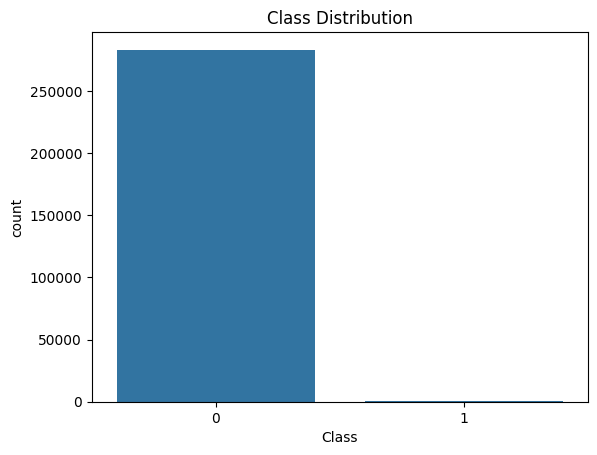

In [7]:
# Define subsets for Normal and Fraudulent transactions
Normal = credit[credit['Class'] == 0]
Fraudulent = credit[credit['Class'] == 1]
# Check for class imbalance
print("Class distribution:\n", credit['Class'].value_counts())
sns.countplot(x='Class', data=credit)
plt.title("Class Distribution")
plt.show()

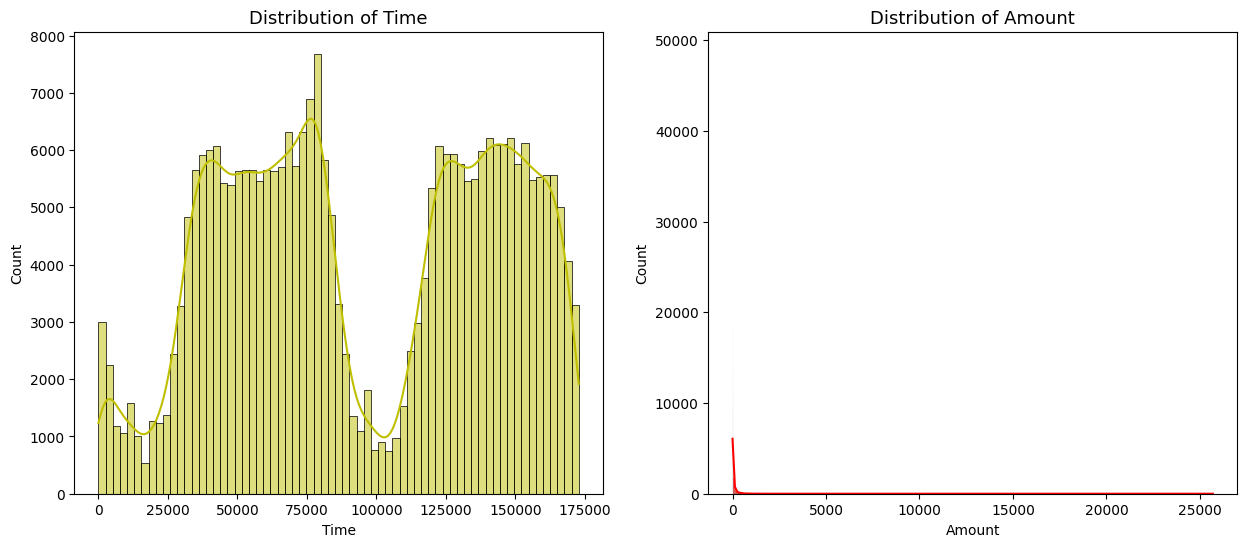

In [8]:
# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot histograms for 'Time' and 'Amount'
sns.histplot(credit['Time'], ax=ax1, color='y', kde=True)
sns.histplot(credit['Amount'], ax=ax2, color='r', kde=True)

# Set titles
ax1.set_title('Distribution of Time', fontsize=13)
ax2.set_title('Distribution of Amount', fontsize=13)

# Show the plot
plt.show()

This step visualizes the distribution of transaction time and amount using histograms with kernel density estimates, helping identify potential patterns or anomalies in the dataset.

from it The **Time** distribution shows a bimodal pattern with two peaks indicating distinct transaction activity periods, while the **Amount** distribution is highly right-skewed, with most transactions concentrated at lower values.

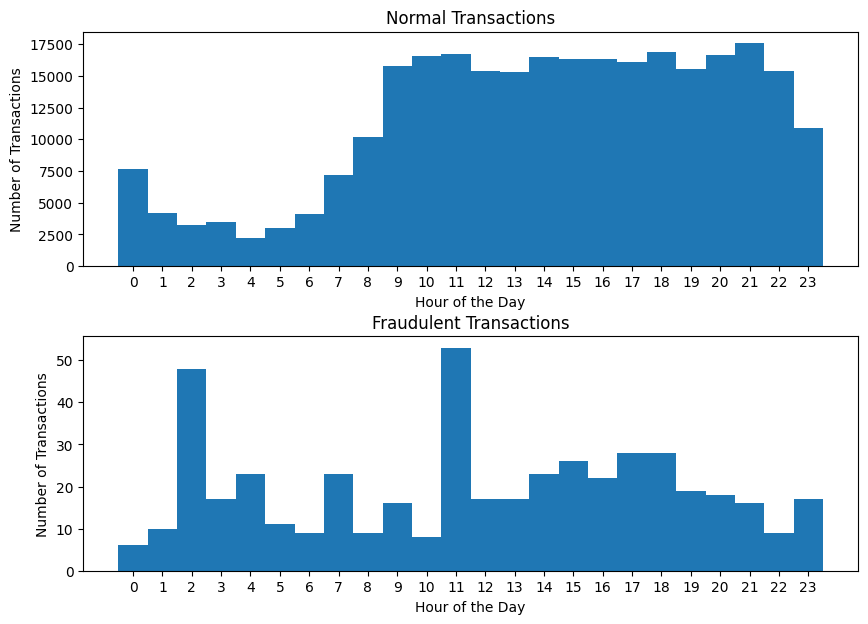

In [9]:
# Extracting hour of the day directly from the 'Time' column
credit["Hour"] = (credit["Time"] // 3600) % 24  # Convert seconds to hours and take modulo 24

# Ploting histograms for Normal and Fraudulent transactions by hour
fig, ax = plt.subplots(2, figsize=(10, 7))
for a in ax:
    a.set_xticks(range(24))

# Normal transactions
credit.loc[credit["Class"] == 0]["Hour"].hist(bins=np.arange(25)-0.5, ax=ax[0], grid=False)
ax[0].title.set_text("Normal Transactions")
ax[0].set_xlabel("Hour of the Day")
ax[0].set_ylabel("Number of Transactions")

# Fraudulent transactions
credit.loc[credit["Class"] == 1]["Hour"].hist(bins=np.arange(25)-0.5, ax=ax[1], grid=False)
ax[1].title.set_text("Fraudulent Transactions")
ax[1].set_xlabel("Hour of the Day")
ax[1].set_ylabel("Number of Transactions")

# Adjust spacing
plt.subplots_adjust(hspace=0.3)
plt.show()

This step extracts the transaction hour from the time column, then visualizes the distribution of normal and fraudulent transactions by hour using histograms, helping identify temporal patterns in fraudulent activity.

Most normal transactions happen during the day, especially between **9 AM and 10 PM**, which matches regular shopping or business hours. Fraudulent transactions, on the other hand, are spread out and have unusual peaks around **2 AM and 11 AM**, suggesting that fraud might be happening when people are less likely to be watching closely.

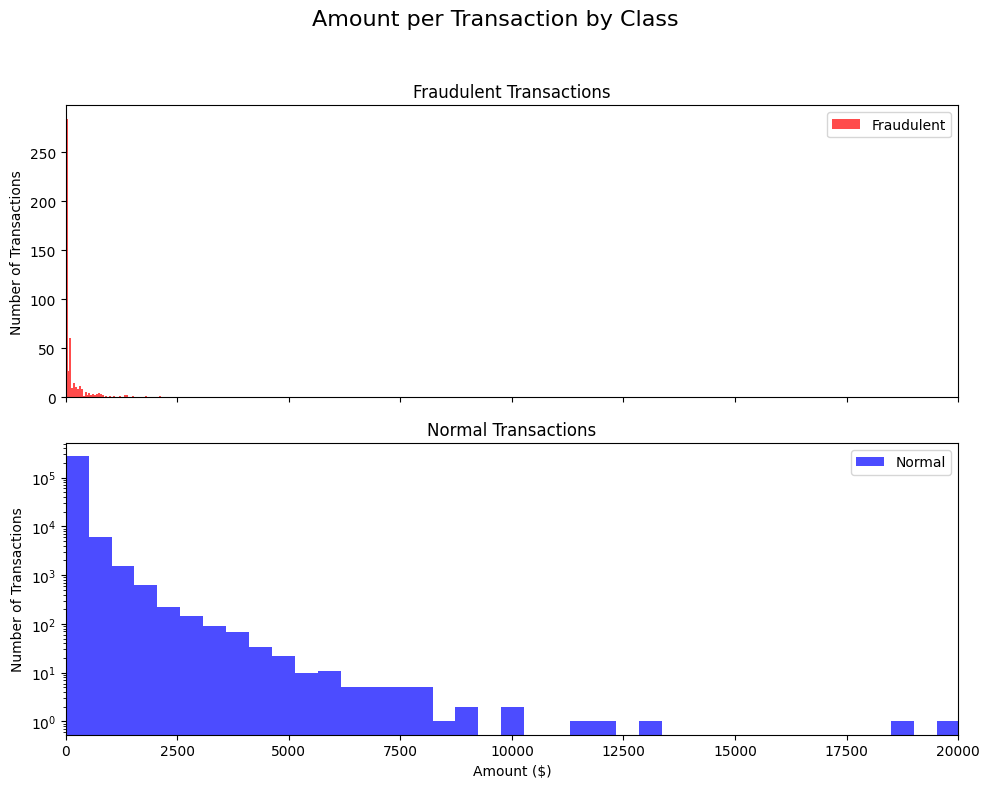

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  # Adjust figure size for better clarity
f.suptitle('Amount per Transaction by Class', fontsize=16)  # Add a larger, descriptive title

bins = 50  # Number of bins for the histogram

# Fraudulent transactions
ax1.hist(Fraudulent.Amount, bins=bins, color='red', alpha=0.7, label='Fraudulent')  # Add color and transparency
ax1.set_title('Fraudulent Transactions', fontsize=12)  # Add a more descriptive title
ax1.set_ylabel('Number of Transactions', fontsize=10)  # Label y-axis
ax1.legend()  # Add a legend for clarity

# Normal transactions
ax2.hist(Normal.Amount, bins=bins, color='blue', alpha=0.7, label='Normal')  # Add color and transparency
ax2.set_title('Normal Transactions', fontsize=12)  # Add a more descriptive title
ax2.set_xlabel('Amount ($)', fontsize=10)  # Label x-axis
ax2.set_ylabel('Number of Transactions', fontsize=10)  # Label y-axis
ax2.legend()  # Add a legend for clarity

# Set consistent x-axis limits and log scale for y-axis
plt.xlim((0, 20000))  # Limit x-axis to focus on relevant range
plt.yscale('log')  # Use log scale for better visualization of skewed data

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

This step visualizes the distribution of transaction amounts for both fraudulent and normal transactions using histograms, highlighting differences in amount patterns and using a log scale for better representation of skewed data.

Fraud usually happens with small amounts, while normal transactions can be small or large, but are mostly small too.

In [11]:
X = credit.drop(['Class','Time'], axis=1)
y = credit['Class']

This step defines the **feature matrix (X)** by dropping the `Class` (target variable) and `Time` columns from the dataset, while **setting the target variable (y)** as `Class` for fraud detection modeling.

Feature Engineering

In [12]:
# Removing constant/quasi-constant features
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0.01)
X_filtered = constant_filter.fit_transform(X)

# Removing highly correlated features
corr_matrix = pd.DataFrame(X_filtered).corr().abs()
high_corr = np.where(corr_matrix > 0.95)
high_corr = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
             for x, y in zip(*high_corr) if x != y and x < y]
to_drop = list(set([col[1] for col in high_corr]))  # Dropping one from each pair

# Selecting the top K features using univariate method
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=20)
X_final = selector.fit_transform(X.drop(to_drop, axis=1), y)

# Geting final feature names
remaining_features = [f for i, f in enumerate(X.columns) 
                     if f not in to_drop and selector.get_support()[i]]

# spliting your data
X_train, X_test, y_train, y_test = train_test_split(
    X[remaining_features], y, test_size=0.2, random_state=42, stratify=y
)

This step **refines feature selection** by:
1. Removing **constant/quasi-constant** features using `VarianceThreshold` to eliminate low-variance predictors.
2. Dropping **highly correlated features** to reduce redundancy and multicollinearity.
3. Selecting the **top 20 features** using `SelectKBest` with `mutual_info_classif` for relevance.
4. **Splitting the dataset** into training and testing sets while maintaining class balance through stratification.

This improves model efficiency and ensures meaningful predictors for fraud detection. 

In [13]:
print(remaining_features)


['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V21', 'V27', 'V28', 'Hour']


**Feature scaling**

In [14]:
scaler = StandardScaler()

# Scale only 'Hour'
X_train[['Hour']] = scaler.fit_transform(X_train[['Hour']])
X_test[['Hour']] = scaler.transform(X_test[['Hour']])


In [15]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)
# Verify the new class distribution
print("Class distribution before oversamplering:", y_train.value_counts())
print("Class distribution after oversamplering:\n", pd.Series(y_train_bal).value_counts())

Class distribution before oversamplering: Class
0    226602
1       378
Name: count, dtype: int64
Class distribution after oversamplering:
 Class
0    226602
1    226596
Name: count, dtype: int64


This step applies **ADASYN (Adaptive Synthetic Sampling)** to **oversample** the minority class by generating synthetic fraudulent transaction samples. ADASYN **adapts the data generation** based on distribution complexity, ensuring a more informative balance. The final print statements verify the new class distribution after resampling.

**MODEL BUILDING AND EVALUATION**

This step systematically **trains, evaluates, and compares** multiple classifiers (**Logistic Regression, Random Forest, Decision Tree, and XGBoost**) for fraud detection. It does the following:

1. **Defines models with tuned hyperparameters**—including regularization, class balancing, and tree depth constraints.
2. **Trains each model** on the oversampled dataset using ADASYN.
3. **Predicts fraud cases** on the test set.
4. **Generates classification reports**, including precision, recall, F1-score, and accuracy.
5. **Visualizes confusion matrices** to highlight fraud detection performance.
6. **Stores key evaluation metrics**, including **ROC-AUC scores** for comparing effectiveness.
7. **Aggregates results into a DataFrame** for structured model comparison.

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56651
           1       0.02      0.93      0.03        95

    accuracy                           0.91     56746
   macro avg       0.51      0.92      0.49     56746
weighted avg       1.00      0.91      0.95     56746



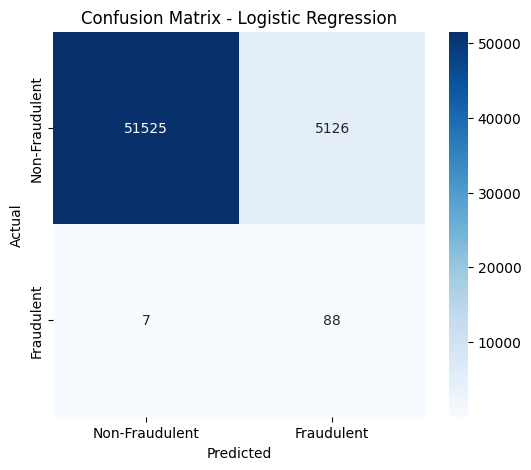

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.85      0.19        95

    accuracy                           0.99     56746
   macro avg       0.55      0.92      0.59     56746
weighted avg       1.00      0.99      0.99     56746



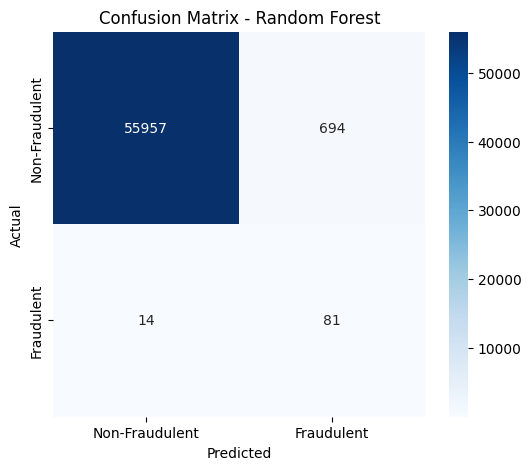

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56651
           1       0.01      0.88      0.02        95

    accuracy                           0.88     56746
   macro avg       0.51      0.88      0.48     56746
weighted avg       1.00      0.88      0.93     56746



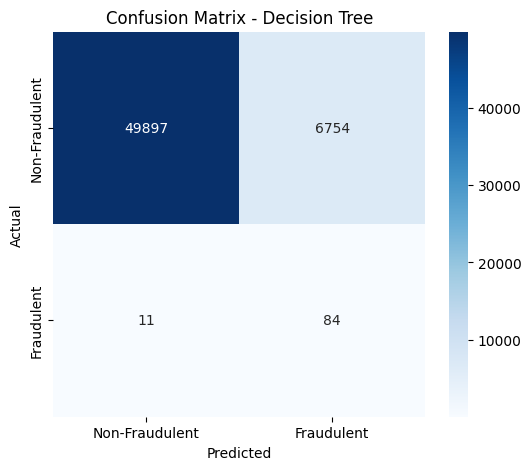

--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56651
           1       0.02      0.92      0.05        95

    accuracy                           0.94     56746
   macro avg       0.51      0.93      0.51     56746
weighted avg       1.00      0.94      0.97     56746



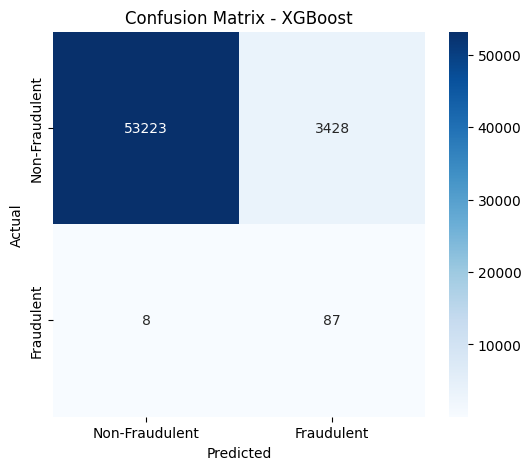


--- Model Comparison ---
                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.909544   0.016878  0.926316  0.033151  0.917916
Random Forest        0.987523   0.104516  0.852632  0.186207  0.920191
Decision Tree        0.880785   0.012284  0.884211  0.024232  0.882495
XGBoost              0.939449   0.024751  0.915789  0.048199  0.927639


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
# Define the models
models = {
    "Logistic Regression": LogisticRegression(
        C=0.1,                   # Inverse of regularization strength (smaller = stronger regularization)
        penalty='l1',            # L1 regularization (sparse solution)
        solver='liblinear',       # Solver that works with L1 penalty
        random_state=42,
        max_iter=1000            # Increase iterations for convergence
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=100,        # Number of trees (keep moderate)
        max_depth=10,            # Limit tree depth
        min_samples_split=10,     # Minimum samples to split a node
        min_samples_leaf=5,       # Minimum samples at a leaf node
        max_features='sqrt',      # Number of features to consider at each split
        random_state=42,
        class_weight='balanced'   # Adjust weights for imbalanced classes
    ),
    
    "Decision Tree": DecisionTreeClassifier(
        max_depth=5,             # Shallower tree
        min_samples_split=10,     # Minimum samples to split a node
        min_samples_leaf=5,       # Minimum samples at a leaf node
        random_state=42,
        class_weight='balanced'  # Adjust weights for imbalanced classes
    ),
    
    "XGBoost": XGBClassifier(
        learning_rate=0.1,        # Shrinkage to prevent overfitting
        max_depth=5,              # Maximum tree depth
        min_child_weight=1,       # Minimum sum of instance weight needed in a child
        gamma=0.1,                # Minimum loss reduction to make a split
        subsample=0.8,            # Subsample ratio of training instances
        colsample_bytree=0.8,     # Subsample ratio of features
        reg_alpha=0.1,           # L1 regularization term
        reg_lambda=1,            # L2 regularization term
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  # Handle class imbalance
    )
}

# Dictionary to store results
results = {}

# Loop over models
for name, model in models.items():
    print(f"--- {name} ---")
    
    # Train the model
    model.fit(X_train_bal, y_train_bal)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Non-Fraudulent", "Fraudulent"], 
                yticklabels=["Non-Fraudulent", "Fraudulent"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Store metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    }

# Create a DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison ---")
print(results_df)

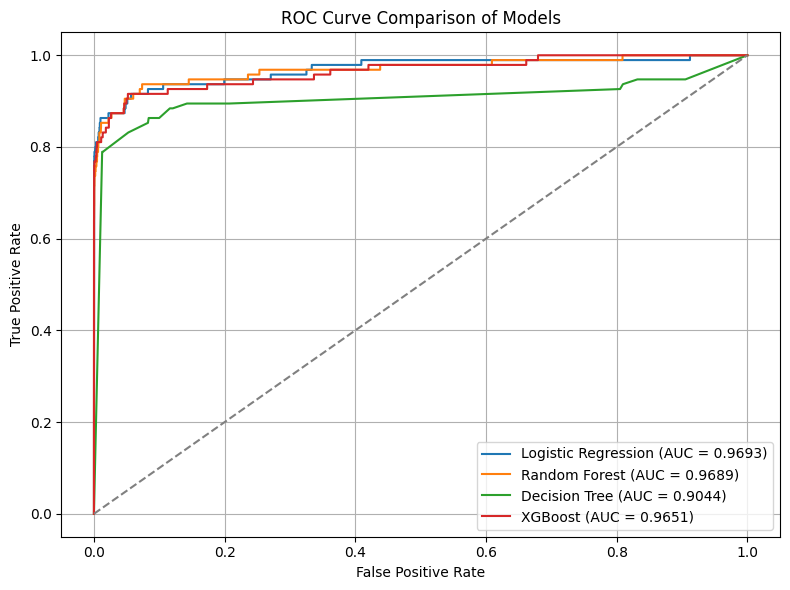

In [17]:
# Dictionary to store fpr, tpr for each model
roc_data = {}

# Loop through each model and calculate ROC data
for name, model in models.items():
    # Predict probabilities for class 1
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store data for plotting
    roc_data[name] = (fpr, tpr, auc)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve Comparison of Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

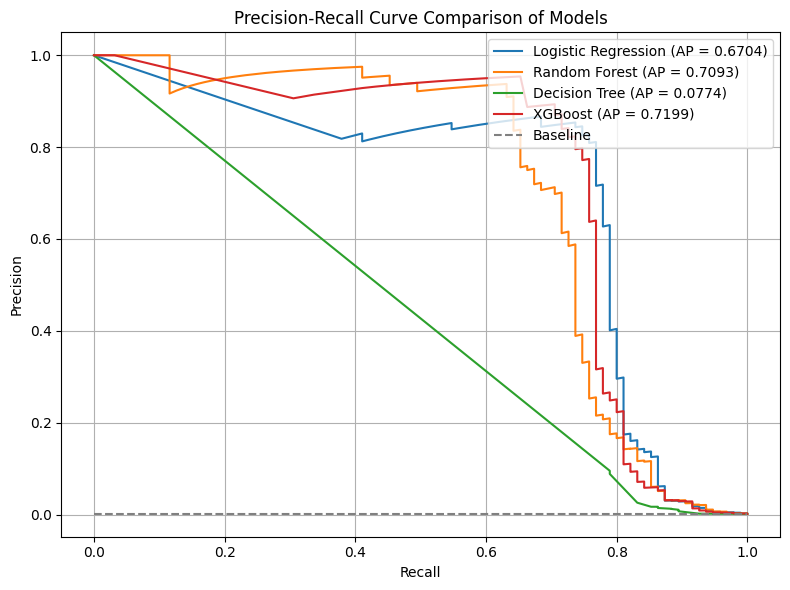

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Dictionary to store precision, recall for each model
pr_data = {}

# Loop through each model and calculate PR data
for name, model in models.items():
    # Predict probabilities for class 1
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_prec = average_precision_score(y_test, y_pred_proba)

    # Store data for plotting
    pr_data[name] = (precision, recall, avg_prec)

# Plot all PR curves
plt.figure(figsize=(8, 6))
for name, (precision, recall, avg_prec) in pr_data.items():
    plt.plot(recall, precision, label=f"{name} (AP = {avg_prec:.4f})")

# Baseline (random model)
positive_rate = y_test.mean()
plt.hlines(positive_rate, 0, 1, linestyle='--', color='gray', label='Baseline')

plt.title("Precision-Recall Curve Comparison of Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


This step fine-tunes an **XGBoost classifier** for fraud detection by:
1. **Defining a parameter grid** for **GridSearchCV** to optimize hyperparameters.
2. Using **Stratified K-Fold cross-validation** for robust evaluation.
3. Selecting the **best model** based on F1-score.
4. **Determining the optimal classification threshold** using precision-recall curves.
5. Evaluating performance with **classification reports, ROC-AUC score, and confusion matrix visualization**.

This approach ensures **balanced fraud detection**, minimizes false positives, and refines decision boundaries. 

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'subsample': 0.8}

Optimal threshold: 0.979 | Max F1: 0.819

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.92      0.74      0.82        95

    accuracy                           1.00     56746
   macro avg       0.96      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC Score: 0.9752826400611686

Evaluation Metrics:
Accuracy:  0.9995
Precision: 0.9211
Recall:    0.7368
F1 Score:  0.8187
ROC AUC:   0.9753


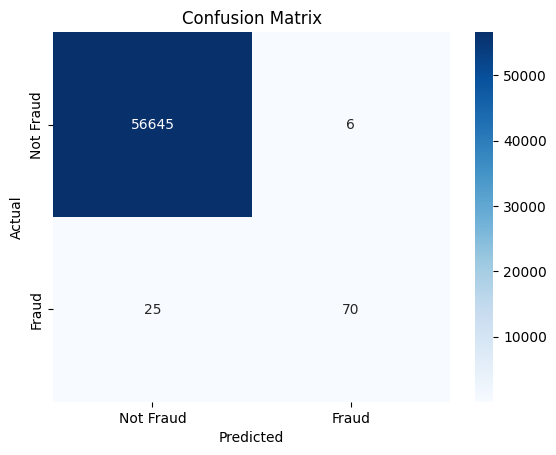

In [19]:
# XGBoost Classifier 
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Parameter Grid 
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2],
    'scale_pos_weight': [1],
    'min_child_weight': [1, 5]
}

# Cross-Validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_bal, y_train_bal)

# Best Model and Predict 
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_proba = best_model.predict_proba(X_test)[:, 1]

# Find Optimal Threshold 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.3f} | Max F1: {f1_scores[optimal_idx]:.3f}")

# Final Predictions
y_pred = (y_proba >= optimal_threshold).astype(int)

# Evaluation 
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix Visualization 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

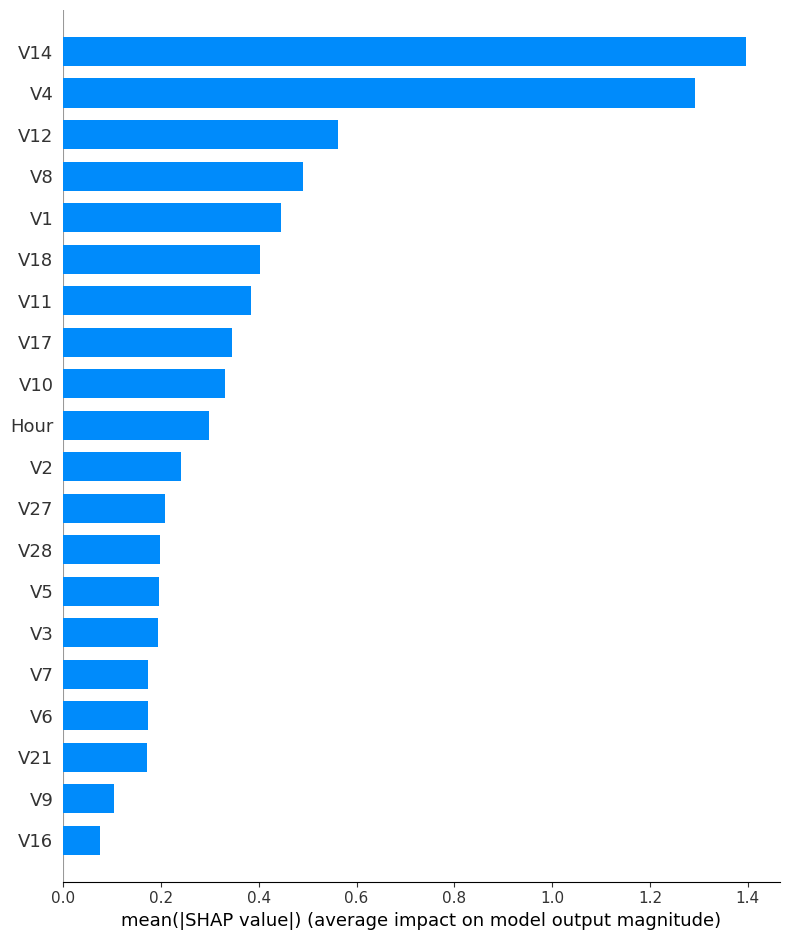

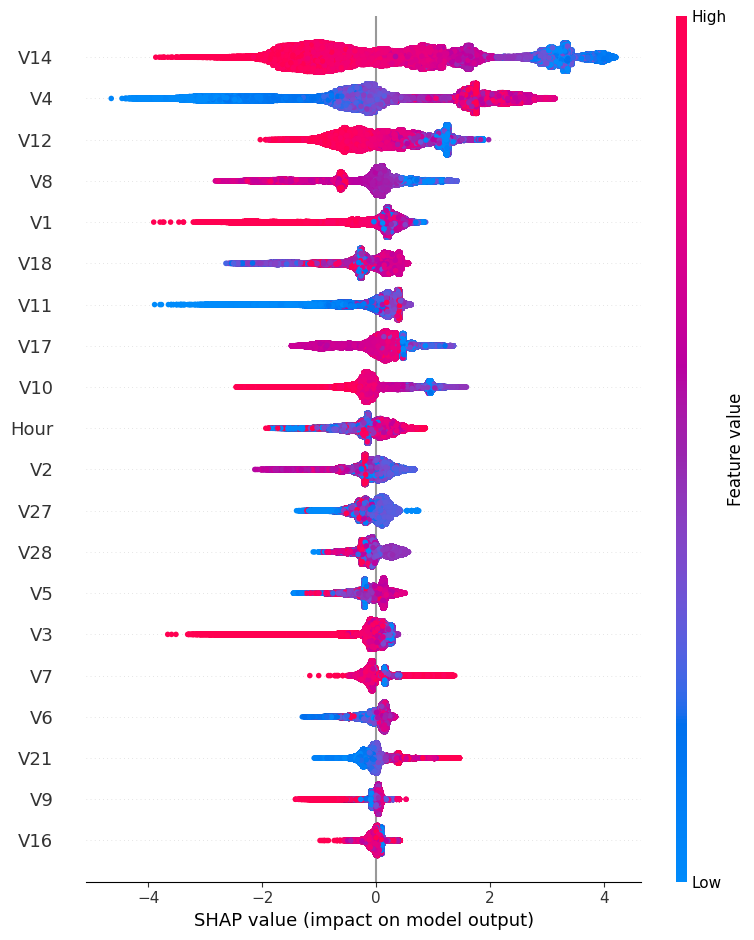

In [20]:
# SHAP Explanation 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_bal)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train_bal, plot_type="bar")
shap.summary_plot(shap_values, X_train_bal)

**Saving the model**

In [21]:
import joblib

# Save model
joblib.dump(best_model, 'xgb_best_model.pkl')

['xgb_best_model.pkl']